In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os
local_dir = 's18-transformer-speeding-up-strategy'
repo_url = 'https://github.com/aakashvardhan/s18-transformer-speeding-up-strategy.git'

# Check if the local directory already exists
if not os.path.exists(local_dir):
    # Clone the repository because it does not exist
    !git clone --quiet {repo_url}
else:
    # Change directory to the local repository
    %cd {local_dir}
    # Pull the latest changes because the repository already exists
    !git pull

In [3]:
import sys
sys.path.append('/content/s18-transformer-speeding-up-strategy')

In [4]:
!pip install -q -r /content/s18-transformer-speeding-up-strategy/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 46.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.2/812.2 kB 50.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 72.6 MB/s eta 0:00:00


In [5]:
%cd /content/s18-transformer-speeding-up-strategy

/content/s18-transformer-speeding-up-strategy


In [6]:
import os
import warnings
import random

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from torchmetrics.text import BLEUScore, CharErrorRate, WordErrorRate

import lightning as L
from lightning.pytorch.callbacks import (
    EarlyStopping,
    LearningRateMonitor,
    ModelCheckpoint,
    TQDMProgressBar,
)
from lightning.pytorch.loggers import TensorBoardLogger

from config_file import get_config, get_weights_file_path
from dataset import LiTDataModule
from utils import get_model, greedy_decode

In [7]:
cfg = get_config()
# cfg['batch_size'] = 24
cfg['num_epochs'] = 18

In [8]:
# Define the directory name
directory_name = "weights"

# Create the directory if it does not exist
if not os.path.exists(directory_name):
  os.makedirs(directory_name)
  print(f"Directory '{directory_name}' created!")
else:
  print(f"Directory '{directory_name}' already exists.")

Directory 'weights' created!


In [9]:
# Clear CUDA cache and set seed
torch.cuda.empty_cache()
L.seed_everything(42, workers=True)
print("Seed set to 42...")

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


Seed set to 42...


In [10]:
# Initialize the data module
datamodule = LiTDataModule(cfg)
datamodule.setup()
print("DataModule initialized...")
tokenizer_src, tokenizer_tgt = datamodule.tokenizer_src, datamodule.tokenizer_tgt
train_dataloader = datamodule.train_dataloader()
# Initialize TensorBoard logger
tb_logger = TensorBoardLogger(
    save_dir=os.getcwd(), version=1, name="lightning_logs"
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/32332 [00:00<?, ? examples/s]

Max length of the source sentence : 43
Max length of the source target : 38
DataModule initialized...


In [11]:
# Initialize the trainer
trainer = L.Trainer(
            precision=cfg["precision"],
            max_epochs=cfg["num_epochs"],
            logger=tb_logger,
            accelerator=cfg["accelerator"],
            devices="auto",
            default_root_dir=cfg["model_folder"],
            callbacks=[
                ModelCheckpoint(
                    dirpath=cfg["model_folder"],
                    save_top_k=3,
                    monitor="train_loss_step",
                    mode="min",
                    filename="model-{epoch:02d}-{train_loss:.4f}",
                    save_last=True,
                ),
                LearningRateMonitor(logging_interval="step", log_momentum=True),
                EarlyStopping(
                    monitor="train_loss_step", mode="min", stopping_threshold=1.6
                ),
                TQDMProgressBar(refresh_rate=10),
            ],
            gradient_clip_val=0.5,
            num_sanity_val_steps=5,
            enable_progress_bar=True,
            check_val_every_n_epoch=1,
            limit_val_batches=2)

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [12]:
from main import LTModel
# Initialize the model
model = LTModel(cfg, tokenizer_src=tokenizer_src, tokenizer_tgt=tokenizer_tgt, train_dataloader=train_dataloader)
print("Model initialized...")

In [13]:
print(cfg["one_cycle_best_lr"])

0.0001


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Max length of the source sentence : 43
Max length of the source target : 38


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


--------------------------------------------------------------------------------
    SOURCE: 'I don't understand...' said he.
    TARGET: — Non capisco — disse lui.
 PREDICTED: lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasc

Finding best initial lr:   0%|          | 0/18 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 64. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
INFO: `Trainer.fit` stopped: `max_steps=18` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=18` reached.
INFO: Learning rate set to 0.005994842503189409
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.005994842503189409
INFO: Restoring states from the checkpoint path at weights/.lr_find_c8f49410-df59-473b-b7a0-599ca24b4bb4.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at weights/.lr_find_c8f49410-df59-473b-b7a0-599ca24b4bb4.ckpt
INFO: Restored all states from the checkpoint at weights/.lr_find_c8f49410-df59-473b-b7a0-599ca24b4bb4.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at weights/.lr_find_c8f49410-df5

Suggested learning rate: 0.005994842503189409


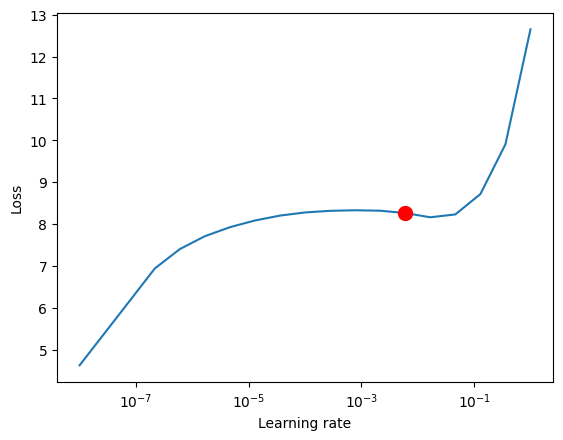

In [14]:
 # Learning rate finder
tuner = L.pytorch.tuner.Tuner(trainer)
lr_finder = tuner.lr_find(
    model, datamodule=datamodule, num_training=trainer.max_epochs
)
print(lr_finder)

# Initialize suggested_lr with a default value
suggested_lr = model.one_cycle_best_lr

if lr_finder:
  fig = lr_finder.plot(suggest=True)
  fig.show()
  suggested_lr = lr_finder.suggestion()
  print(f"Suggested learning rate: {suggested_lr}")
else:
  print("Learning rate finding did not complete successfully.")

# Set the best learning rate
model.one_cycle_best_lr = suggested_lr

In [15]:
print(model.one_cycle_best_lr)

0.005994842503189409


In [16]:
trainer.fit(model=model, datamodule=datamodule)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Transformer      | 34.9 M | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
34.9 M    Trainable params
0         Non-trainable params
34.9 M    Total params
139.716   Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Transformer      | 34.9 M | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
34.9 M    Trainable params
0         Non-trainable params
34.9 M    Total params
139.716   Total estimated model params size (MB)


Max length of the source sentence : 43
Max length of the source target : 38


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

--------------------------------------------------------------------------------
    SOURCE: 'I don't understand...' said he.
    TARGET: — Non capisco — disse lui.
 PREDICTED: lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasc

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 52. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

--------------------------------------------------------------------------------
    SOURCE: And he loves me; All this has been, but will pass,' she said, feeling that tears of joy at this return to life were running down her cheeks.
    TARGET: Perché lui mi ama! Questo è stato e passerà” ella diceva, sentendo che le lacrime della gioia del ritorno alla vita le scorrevano per le guance.
 PREDICTED: — No , non è una , — disse , ma non è una .
--------------------------------------------------------------------------------
    SOURCE: 'I don't understand...' said he.
    TARGET: — Non capisco — disse lui.
 PREDICTED: lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciav

Validation: |          | 0/? [00:00<?, ?it/s]

--------------------------------------------------------------------------------
    SOURCE: One has to take a decision,' he said. 'Anything would be better than the condition in which you are living.
    TARGET: Bisogna decidersi — egli disse. — Qualunque cosa è migliore della posizione in cui vivi.
 PREDICTED: trecciolina trecciolina lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasci

Validation: |          | 0/? [00:00<?, ?it/s]

--------------------------------------------------------------------------------
    SOURCE: "Mr. Rivers! you quite put me out of patience: I am rational enough; it is you who misunderstand, or rather who affect to misunderstand."
    TARGET: — Signor Rivers, mi farete perder la pazienza; sono calma; siete voi che non capite, o che fingete di non capirmi.
 PREDICTED: — Sì , signore , signore , signore , signore , signore , signore , signore , signore , signore , signore , signore , signore , signore , signore , signore , signore , signore , signore , signore , signore , signore , signore , signore , signore , signore , signore , signore , signore , signore , signore , signore , signore , signore , signore , signore , signore , signore , signore , signore , signore , signore , signore , signore , signore , signore , signore , signore , signore , signore , signore , signore , signore , signore , signore , signore , signore , signore , signore , signore , signore , signore , signore , sig

Validation: |          | 0/? [00:00<?, ?it/s]

--------------------------------------------------------------------------------
    SOURCE: If I tear, if I rend the slight prison, my outrage will only let the captive loose.
    TARGET: "Se infrango la fragile prigione, rendo la libertà al prigioniero.
 PREDICTED: lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava las

In [ ]:
# Validate the model
trainer.validate(model=model, datamodule=datamodule)
print("Model Evaluation Done...")

In [ ]:
# Save the model
torch.save(model.state_dict(), "saved_resnet18_model.pth")
print("Model saved...")

In [ ]:
# start tensorboard
%load_ext tensorboard
%tensorboard --logdir /content/s18-transformer-speeding-up-strategy/lightning_logs